#Installing Libraries and Dataset

In [ ]:
#-----------------------------------------------------#
#                   Library imports                   #
#-----------------------------------------------------#
#                 Important Libraries                 #
#-----------------------------------------------------#
import os
import json
import tensorflow as tf
import random, os
import sys
import shutil
from matplotlib.image import imread
import sklearn
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import random
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.mobilenet import MobileNet
from keras.metrics import AUC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

#Dataset Imports

In [ ]:
#-----------------------------------------------------#
#                       Datasets                      #
#-----------------------------------------------------#

os.environ["CUDA_VISIBLE_DEVICES"]="0"
#test set
!wget https://www.dropbox.com/s/yoj3ndvzyyo34xd/test.zip?dl=0
#training set
!wget https://www.dropbox.com/s/4rkw32gm8pfrge4/Training_Set.zip?dl=0
#validation set
!wget https://www.dropbox.com/s/5somd89mfa31zz9/validation.zip?dl=0
import zipfile
# Unzip the training set
with zipfile.ZipFile('/content/Training_Set.zip?dl=0', 'r') as zip_ref:
    zip_ref.extractall('training_folder')

# Unzip the validation set
with zipfile.ZipFile('/content/test.zip?dl=0', 'r') as zip_ref:
    zip_ref.extractall('test_folder')

# Unzip the testing set
with zipfile.ZipFile('/content/validation.zip?dl=0', 'r') as zip_ref:
    zip_ref.extractall('validation_folder')
!rm /content/Training_Set.zip?dl=0
!rm /content/test.zip?dl=0
!rm /content/validation.zip?dl=0

!mkdir /content/Upsampled_Set
!mv /content/test_folder /content/Upsampled_Set/
!mv /content/training_folder /content/Upsampled_Set/
!mv /content/validation_folder /content/Upsampled_Set/


--2023-02-18 05:32:09--  https://www.dropbox.com/s/yoj3ndvzyyo34xd/test.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/yoj3ndvzyyo34xd/test.zip [following]
--2023-02-18 05:32:09--  https://www.dropbox.com/s/raw/yoj3ndvzyyo34xd/test.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc664a1667d16f039bd3641d5c22.dl.dropboxusercontent.com/cd/0/inline/B2v_68RtflBvPgMIWV1MJJLghdFyuwIjwp9KUfIc_eniOLyuV0BuRfJMK0Jz1xQqwgZkytLF4kPi64DwypHAPPVKta2tjS8qNcmz9geJO4tNanB1NndcNaxRrP52qhD1S8bQgHQna6umvmYYqMVxQS4fhp61UUOeigAqfcGy3Nt8Og/file# [following]
--2023-02-18 05:32:09--  https://uc664a1667d16f039bd3641d5c22.dl.dropboxusercontent.com/cd/0/inline/B2v_68RtflBvPgMIWV1MJJLghdFyuwIjwp9KUfIc_eniOLyuV0BuRfJMK0Jz1xQqwgZkytLF4kPi64DwypHA

#Building dataframes/constructors for diseases

In [ ]:
#-----------------------------------------------------#
#                   Configurations                    #
#-----------------------------------------------------#

# Provide pathes to imaging and annotation data
path_riadd = "/content/Upsampled_Set"

# Define some parameters
k_fold = 5
input_shape = (224, 224)

# Define architecture which should be processed
arch = "DenseNet169"

In [ ]:
#-----------------------------------------------------#
#          AUCMEDI Classifier Setup for RIADD         #
#-----------------------------------------------------#

# Define the path to the csv file containing the training labels
path_csv = '/content/Upsampled_Set/training_folder/RFMiD_Training_Labels.csv'

# Load the data from the csv file
df = pd.read_csv(path_csv)

# Create a dictionary with the ID column
data = {'ID': [i for i in range(1, 1921)]}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Write the DataFrame to a csv file
df.to_csv("file_names.csv", index=False)


# Get the number of classes
num_classes = df['ID'].nunique()

# Get the number of samples for each class
samples_per_class = [len(df[df['ID'] == i]) for i in range(num_classes)]

# Get the total number of samples
num_samples = len(df)

# Get the indices of the samples
indices = np.arange(num_samples)

# Shuffle the indices to randomly select the samples
np.random.shuffle(indices)

# Select the sample indices
sample_indices = indices[:num_samples]

# !!! undefined variables 'image_files' and 'labels' !!!
# sample_image_files = [image_files[i] for i in sample_indices]
# sample_labels = [labels[i] for i in sample_indices]

# Save the sampling information to a numpy array
np.save('sample_indices.npy', sample_indices)
# np.save('sample_image_files.npy', sample_image_files)
# np.save('sample_labels.npy', sample_labels)

In [ ]:
import pandas as pd
import random

# Load the data from the csv file into a pandas dataframe
data = pd.read_csv("/content/Upsampled_Set/training_folder/RFMiD_Training_Labels.csv")

# Drop any columns that have all NaN values
data.dropna(axis=1, how='all', inplace=True)

# Create a list of unique disease names
disease_names = data.columns.tolist()[1:]

# Initialize a dictionary to store the data for each disease
data_by_disease = {disease: None for disease in disease_names}

# Loop through each disease name and create a new dataframe for that disease
for disease in disease_names:
    # Create a dataframe for each disease with columns ID, label and filepath
    data_by_disease[disease] = data[['ID', disease]]
    data_by_disease[disease].rename(columns={disease: 'label'}, inplace=True)
    data_by_disease[disease]['label'] = data_by_disease[disease]['label'].astype(str)
    data_by_disease[disease]['label'].replace({'0': 'negative', '1': disease}, inplace=True)
    data_by_disease[disease]['filepath'] = "/content/Upsampled_Set/training_folder/images/" + data_by_disease[disease]['ID'].astype(str) + ".jpeg"

# Create a list of filepaths and labels for each disease
data_by_disease_list = {disease: None for disease in disease_names}
for disease in disease_names:
    data_by_disease_list[disease] = [(row['filepath'], row['label']) for index, row in data_by_disease[disease].iterrows()]

# Shuffle the data for each disease
for disease in disease_names:
    random.shuffle(data_by_disease_list[disease])

# Split the data into training and validation sets
training_ratio = 0.8
for disease in disease_names:
    num_training = int(training_ratio * len(data_by_disease_list[disease]))
    data_by_disease_list[disease] = {'training': data_by_disease_list[disease][:num_training],
                                     'validation': data_by_disease_list[disease][num_training:]}

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image dimensions
img_width, img_height = 256, 256

# Define the number of classes
num_classes = len(disease_names)

# Define the ImageDataGenerator to augment the training data
train_datagen = ImageDataGenerator(rescale=1./255)

# Define the generator to read the training data
train_generator = train_datagen.flow_from_directory(
    '/content/Upsampled_Set/training_folder/',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical')

# Define the ImageDataGenerator to augment the validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Define the generator to read the validation data
val_generator = val_datagen.flow_from_directory(
    '/content/Upsampled_Set/validation_folder/',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical')

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-5-1179b0b74b6a>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_by_disease[disease]['label'] = data_by_disease[disease]['label'].astype(str)
/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

Found 1920 images belonging to 1 classes.
Found 640 images belonging to 1 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image dimensions
img_width, img_height = 256, 256

# Define the number of classes
num_classes = len(disease_names)

np.random.seed(42)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# flatten images
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# normalize inputs from 0-255 to 0-1
x_train = x_train / 255
x_test = x_test / 255

# one hot encode outputs
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# define the model
model = Sequential()
model.add(Dense(512, input_shape=(784,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the model
model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.2)

# evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)
print('Loss:', score[0])
print('Accuracy:', score[1])

11490434/11490434 [==============================] - 2s 0us/step
Epoch 1/20
375/375 [==============================] - 7s 5ms/step - loss: 0.2801 - accuracy: 0.9161 - val_loss: 0.1287 - val_accuracy: 0.9618
Epoch 2/20
375/375 [==============================] - 2s 4ms/step - loss: 0.1138 - accuracy: 0.9659 - val_loss: 0.0997 - val_accuracy: 0.9696
Epoch 3/20
375/375 [==============================] - 1s 4ms/step - loss: 0.0791 - accuracy: 0.9752 - val_loss: 0.0823 - val_accuracy: 0.9739
Epoch 4/20
375/375 [==============================] - 2s 4ms/step - loss: 0.0591 - accuracy: 0.9814 - val_loss: 0.0813 - val_accuracy: 0.9754
Epoch 5/20
375/375 [==============================] - 2s 6ms/step - loss: 0.0481 - accuracy: 0.9844 - val_loss: 0.0797 - val_accuracy: 0.9765
Epoch 6/20
375/375 [==============================] - 1s 4ms/step - loss: 0.0409 - accuracy: 0.9864 - val_loss: 0.0765 - val_accuracy: 0.9791
Epoch 7/20
375/375 [==============================] - 1s 4ms/step - loss: 0.0352 - 

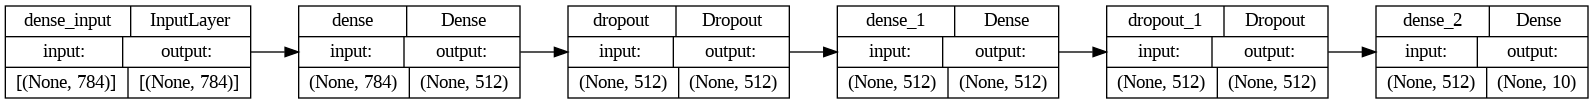

In [ ]:
from tensorflow.keras.utils import plot_model

# Visualize the model
plot_model(model, to_file='model.png', show_shapes=True, rankdir='LR')